<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Осмотр-данных" data-toc-modified-id="Осмотр-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Осмотр данных</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Разбиваем-на-выборки" data-toc-modified-id="Разбиваем-на-выборки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Разбиваем на выборки</a></span></li><li><span><a href="#Векторизируем" data-toc-modified-id="Векторизируем-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Векторизируем</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Построим модель, которая будет классифицировать комментарии на позитивные и негативные.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:,.2f}'.format

### Осмотр данных

In [2]:
df_toxic = pd.read_csv(r'datasets/toxic_comments.csv')
df_toxic.shape

(159571, 2)

In [3]:
df_toxic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
df_toxic['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

<AxesSubplot:>

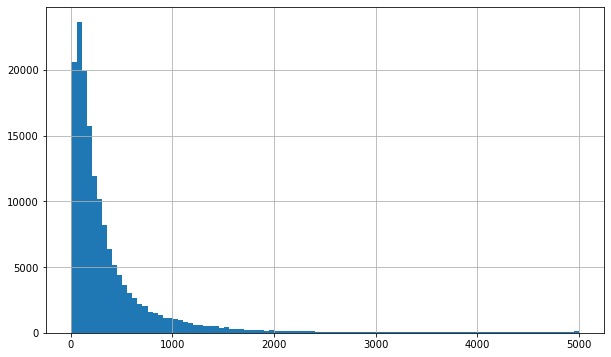

In [5]:
df_toxic['len_comm'] = df_toxic['text'].apply(lambda x: len(x))
df_toxic['len_comm'].hist(bins=100, figsize =(10,6))

<div style="border:solid green 2.0px; padding: 10px"> 

Для ускорения работы оставим в сообщениях только первые 2000 символов
    
</div>

In [6]:
df_toxic = df_toxic.query('len_comm<=2000')

<AxesSubplot:>

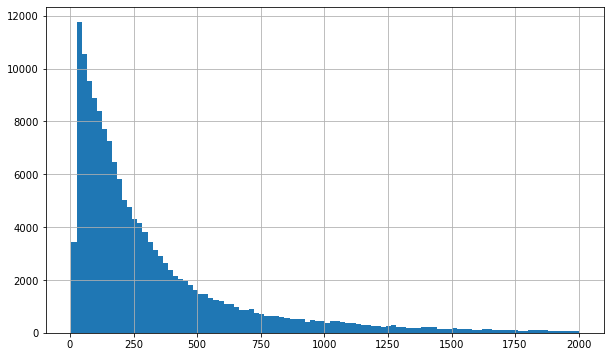

In [7]:
df_toxic['len_comm'].hist(bins=100, figsize =(10,6))

In [8]:
#df_toxic = df_toxic.sample(n=10000)

### Лемматизация

In [10]:
nltk.download('wordnet')
nltk.download('punkt')

wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASGaiduk-h\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASGaiduk-h\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
wnl = WordNetLemmatizer()
def lemmatize(text):
    pattern = r'[^a-zA-Z]'
    text_clear = re.sub(pattern, ' ', text) 
    words_list = nltk.word_tokenize(text_clear.lower())
    
    return " ".join(words_list)

In [13]:
lemmatize("At eight o'clock on Thursday morning Arthur didn't feels very good.")

'at eight o clock on thursday morning arthur didn t feels very good'

In [14]:
df_toxic['text_lemm'] = df_toxic['text'].apply(lemmatize)

In [15]:
df_toxic = df_toxic.drop('text', axis=1)

### Разбиваем на выборки

In [16]:
data_train, data_notrain = train_test_split(df_toxic, test_size=0.5, random_state=12345)
data_test, data_valid = train_test_split(data_notrain, test_size=0.5, random_state=12345)

print(f'Размер исходной выборки: {df_toxic.shape}')

print(f'Размер обучающей выборки: {data_train.shape}')
print(f'Размер валидационной выборки: {data_valid.shape}')
print(f'Размер тестовой выборки: {data_test.shape}')

Размер исходной выборки: (155522, 3)
Размер обучающей выборки: (77761, 3)
Размер валидационной выборки: (38881, 3)
Размер тестовой выборки: (38880, 3)


### Векторизируем

In [17]:
corpus_train = data_train['text_lemm'].values.astype('U')
corpus_valid  = data_valid['text_lemm'].values.astype('U')
corpus_test  = data_test['text_lemm'].values.astype('U')

target_train = data_train['toxic']
target_valid = data_valid['toxic']
target_test = data_test['toxic']

In [18]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASGaiduk-h\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [20]:
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test)

## Обучение

<div style="border:solid green 2.0px; padding: 10px"> 

Обучим несколько разных моделей и выберем лучшую.
    
</div>

In [21]:
CV=3
SCORING='f1'

In [40]:
def test_models(best_params, model_type, feature_train, target_train, feature_test, target_test):
    
    model = model_type(**best_params)
    model.fit(tf_idf_train, target_train)
    predict_valid = model.predict(tf_idf_valid)
    return f1_score(target_valid, predict_valid)

### LogisticRegression

In [41]:
param = {
    'C': [1000, 100, 10, 1, 0.1, 0.01]
       }

clf = GridSearchCV(LogisticRegression(), param, cv = CV, scoring=SCORING)
clf.fit(tf_idf_train, target_train)
clf.best_score_

0.749215489445841

In [42]:
lr_best_params = clf.best_params_
lr_best_params

{'C': 100}

In [43]:
test_models(lr_best_params, LogisticRegression, tf_idf_train, target_train, tf_idf_valid, target_valid)

0.7590227651304831

### RandomForestClassifier

In [44]:
param = {
    'max_depth': range(1, 10, 3),
    'n_estimators': range(10, 50, 10),
    'class_weight': ['balanced']
}

clf = GridSearchCV(RandomForestClassifier(), param, cv = CV, scoring=SCORING)
clf.fit(tf_idf_train, target_train)
clf.best_score_

0.35122250576760905

In [45]:
rf_best_params = clf.best_params_
rf_best_params

{'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 40}

In [47]:
test_models(rf_best_params, RandomForestClassifier, tf_idf_train, target_train, tf_idf_valid, target_test)

0.3410852713178295

### LGBMClassifier

In [48]:
param = {
    'objective': ['regression'], 
    'learning_rate': [0.1],
    'num_leaves': range(10, 100, 20),
    'max_depth': [2, 4, 6, 8, 10],
    'subsample': [0.8], 
    'colsample_bytree': [0.8],
    'class_weight': ['balanced']
    }

In [49]:
clf = GridSearchCV(LGBMClassifier(), param, cv = CV, scoring=SCORING)
clf.fit(tf_idf_train, target_train)
clf.best_score_

0.7076339386101062

In [50]:
lgbm_best_params = clf.best_params_
lgbm_best_params


{'class_weight': 'balanced',
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 10,
 'num_leaves': 90,
 'objective': 'regression',
 'subsample': 0.8}

In [51]:
test_models(lgbm_best_params, LGBMClassifier, tf_idf_train, target_train, tf_idf_valid, target_valid)

0.7125785388690403

### Вывод

<div style="border:solid green 2.0px; padding: 10px"> 

**На валидационной выборке** по метрике f1:

 - Лучшее качество показала модель LogisticRegression: f1 = 0.76
   - Гиперпараметры:
     - 'C' = 100

    
 - На втором месте LGBMClassifier: f1 = 0.71
   - Гиперпараметры:
     - class_weight'= 'balanced'
     - max_depth'= 7
     - n_estimators'= 40

    
 - На третьем месте с сильным отставанием RandomForestClassifier: f1 = 0.37
    
    
Проверим на тестовой выборке модели LogisticRegression и RandomForestClassifier.
    
</div>

## Тестирование

### LogisticRegression

In [52]:
test_models(lr_best_params, LogisticRegression, tf_idf_train, target_train, tf_idf_test, target_test)

0.7590227651304831

### LGBMClassifier

In [53]:
test_models(lgbm_best_params, LGBMClassifier, tf_idf_train, target_train, tf_idf_test, target_test)

0.7125785388690403

## Выводы

<div style="border:solid green 2.0px; padding: 10px"> 

Для нашей задачи лучше всего показала себя модель логистической регрессии (f1 на тестовой выборке равна 0.76)
    
Модель градиентного бустинга показала себя так же не плохо (f1 на тестовой выборке равна 0.71)

Модель случайного леса подошла плохо
    
   
</div>